## TAsk - 1: Machine Learning

### Libraries: 
The following section proceeds to load the necessary libraries for the project.

In [40]:
#############
# Librerías #
#############

# -----------------------------------------
# Generales: Menejo de data y Visualización  
# -----------------------------------------
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import random
import re
import seaborn as sns
import sqlite3

# -----------------------------------------
# Generales: Sklearn  
# -----------------------------------------

# ---- split data
from sklearn.model_selection import train_test_split 

# ---- multiclass classification
from sklearn.preprocessing import LabelEncoder

# ---- Métricas problema de classificación
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay, f1_score

# ---- Métricas problema continuo (regresor)
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error

# ---- Encoder and Scaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from category_encoders import CatBoostEncoder

# ---- Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

# ---- Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

# ---- Xgboost
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.utils.class_weight import compute_sample_weight

# ---- SVM
from sklearn.svm import SVC
from sklearn.svm import SVR

# ---- Tunning Hiperparámetros
from sklearn.model_selection import GridSearchCV

# ---- Redes neuronales 
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
import visualkeras
from sklearn.utils.class_weight import compute_class_weight

### PART 1: Data Cleaning, Preparation, and Feature Engineering

In this section, the main focus was on **data cleaning and preparation**, without performing exploratory data analysis, as this was already carried out in **Part 1**.

The objective of this stage was to ensure that the dataset was properly structured, free of inconsistencies, and included the necessary variables for the subsequent phases of analysis or modeling.

First, the data was loaded from the `laliga.sqlite` database using an SQL query and stored in a **pandas** DataFrame. Then, the variable types were verified, and the `date` column was converted to **datetime** format, correcting out-of-range dates (for example, records from the year 2028 were adjusted to 1928).

Next, **missing values** were analyzed, revealing that the `time` variable contained more than 60% of null values, which led to its removal from the dataset. Missing values in the `score` column were also reviewed, identifying the affected periods, and it was confirmed that there were no duplicate records.

Finally, the `score` column was split into two new numeric variables: `home_goals` and `away_goals`, representing the goals scored by the home and away teams, respectively. Based on these, a new categorical variable `result` was created to classify the match outcome as:
- `0`: home team win  
- `1`: away team win  
- `2`: draw  

Additionally, several **new derived variables** were created to enrich the dataset and capture contextual and performance-related information about each team. These include:

- **`season_start`**: the starting year of each season, extracted from the `season` variable to facilitate chronological ordering.  
- **`home_ranking` and `away_ranking`**: the league ranking of each team (home and away) prior to the match, calculated based on accumulated points, goal difference, and goals scored.  
- **`home_pts` and `away_pts`**: accumulated points for each team before the match, considering previous performance within the same season and division.  
- **`home_gd` and `away_gd`**: accumulated goal difference (goals for minus goals against) before the match.  
- **`HGD_last5` and `AGD_last5`**: average goal difference over the **last five matches** (excluding the current one) for the home and away teams, respectively, serving as indicators of recent form in terms of attack and defense.  
- **`Hpts_last5` and `Apts_last5`**: average number of points obtained in the **last five matches** for each team, reflecting recent performance based on results (wins, draws, or losses).  
- **`hist_home_win_ratio` and `hist_away_win_ratio`**: historical win ratios for the home and away teams, computed based on their **head-to-head (H2H)** encounters during the **previous five seasons**.  
  - These variables capture the historical trend of the matchup while avoiding data leakage, as only past matches were considered.

In cases where historical information was insufficient, **neutral or logical imputations** were applied:
- Missing values in H2H indicators were filled with `0.5`, representing a neutral probability.  
- Recent form averages (`HGD_last5`, `AGD_last5`, `Hpts_last5`, `Apts_last5`) were filled with `0.0` for teams with few or no previous matches.  
- Previous rankings at the start of the season were filled with the total number of teams in the league, assigning the lowest possible ranking.

As a result of this process, a **clean, consistent, and enriched dataset** was obtained, containing newly engineered features that reflect both the current and historical performance of the teams. This final dataset is now ready to be used in the subsequent stages of **predictive modeling and analysis**.

In [41]:
#############
# Read Data #
#############

# Conectar a la base
conn = sqlite3.connect(r"C:\Users\valeu\Desktop\Proyecto Estel\Master UAB\RI\LaLiga\la-quiniela-main\la-quiniela-main\laliga.sqlite")


# Leer la tabla Matches
df = pd.read_sql_query("SELECT * FROM Matches;", conn)

# Exportar a CSV
df.to_csv("matches.csv", index=False)

# Cerrar conexión
conn.close()

print(" Archivo 'matches.csv' exportado correctamente.")

# Leer el CSV
df = pd.read_csv(r"C:\Users\valeu\Desktop\Proyecto Estel\Master UAB\RI\LaLiga\matches.csv")
df.head()

 Archivo 'matches.csv' exportado correctamente.


,season,division,matchday,date,time,home_team,away_team,score
0,1928-1929,1,1,2/10/29,NaN,Arenas Club,Athletic Madrid,2:3
1,1928-1929,1,1,2/10/29,NaN,Espanyol,Real Unión,3:2
2,1928-1929,1,1,2/10/29,NaN,Real Madrid,Catalunya,5:0
3,1928-1929,1,1,2/10/29,NaN,Donostia,Athletic,1:1
4,1928-1929,1,1,2/12/29,NaN,Racing,Barcelona,0:2


In [42]:
#######
# EDA #
#######

# ----------------------
# Shape 
# ----------------------

print(df.shape)

(48780, 8)


In [43]:
# ----------------------
# Tail
# ----------------------

df.tail()

,season,division,matchday,date,time,home_team,away_team,score
48775,2021-2022,2,42,5/29/22,NaN,Real Oviedo,UD Ibiza,NaN
48776,2021-2022,2,42,5/29/22,NaN,Real Sociedad B,Real Zaragoza,NaN
48777,2021-2022,2,42,5/29/22,NaN,Sporting Gijón,UD Las Palmas,NaN
48778,2021-2022,2,42,5/29/22,NaN,CD Tenerife,FC Cartagena,NaN
48779,2021-2022,2,42,5/29/22,NaN,Real Valladolid,SD Huesca,NaN


In [44]:
# ----------------------
# Info
# ----------------------

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48780 entries, 0 to 48779
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   season     48780 non-null  object
 1   division   48780 non-null  int64 
 2   matchday   48780 non-null  int64 
 3   date       48780 non-null  object
 4   time       16730 non-null  object
 5   home_team  48780 non-null  object
 6   away_team  48780 non-null  object
 7   score      48000 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.0+ MB


In [45]:
# ------------------------------------
# Treatment of Dtype of variables
# ------------------------------------

# ------------------
# date to datetime
# ------------------

# asegurar que la columna date existe
df['date'] = pd.to_datetime(df['date'], errors='coerce', format='%m/%d/%y')

# corregir años futuros (por ejemplo 2028 → 1928)
df.loc[df['date'] > pd.Timestamp('2025-01-01'), 'date'] = df.loc[df['date'] > pd.Timestamp('2025-01-01'), 'date'] - pd.DateOffset(years=100)

# verificar tipo y rango
print("Tipo de dato:", df['date'].dtype)
print("Fecha más antigua:", df['date'].min().date())
print("Fecha más reciente:", df['date'].max().date())

Tipo de dato: datetime64[ns]
Fecha más antigua: 1929-02-10
Fecha más reciente: 2022-05-29


In [46]:
# ------------------
# check
# ------------------
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48780 entries, 0 to 48779
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   season     48780 non-null  object        
 1   division   48780 non-null  int64         
 2   matchday   48780 non-null  int64         
 3   date       48780 non-null  datetime64[ns]
 4   time       16730 non-null  object        
 5   home_team  48780 non-null  object        
 6   away_team  48780 non-null  object        
 7   score      48000 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 3.0+ MB


Total of missing values: 32830
Missing values by columns: 
 season           0
division         0
matchday         0
date             0
time         32050
home_team        0
away_team        0
score          780
dtype: int64


<Axes: title={'center': '% of missing values by colums'}>

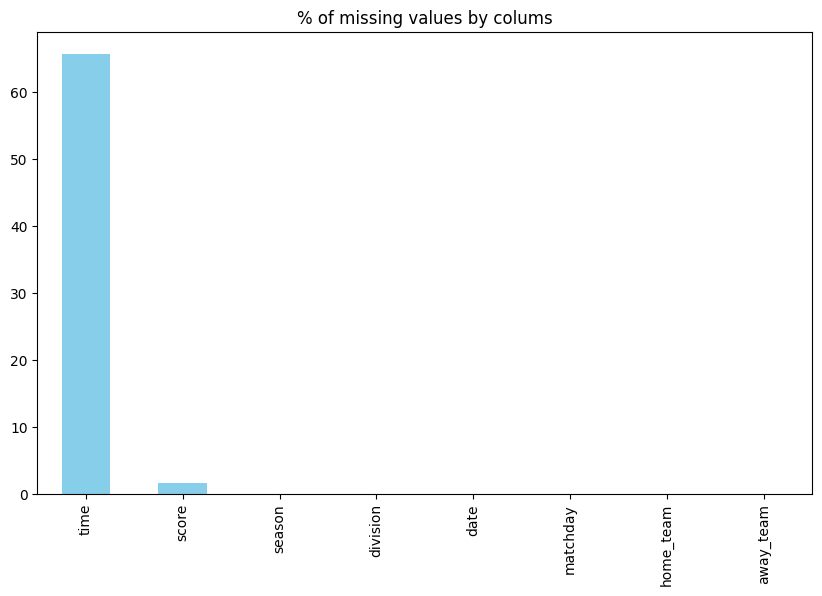

In [47]:
# ----------------------
# NA's
# ----------------------

# total of Na´s
print(f"Total of missing values: {df.isna().sum().sum()}")

# verification of missing values by columns
print(f"Missing values by columns: \n {df.isna().sum()}")

# plot of missing values
df.isnull().mean().mul(100).sort_values(ascending=False).plot(kind='bar', figsize=(10,6), color='skyblue', title='% of missing values by colums')

In [48]:
# ----------------------
# Treatment of NA's
# ----------------------

# delete colum time 
df = df.drop("time", axis=1)

In [49]:
# column score
print(f"Los valores nulos en 'score' van desde {df.loc[df['score'].isna(), 'date'].min().date()} hasta {df.loc[df['score'].isna(), 'date'].max().date()}.")

Los valores nulos en 'score' van desde 2021-08-30 hasta 2022-05-29.


In [50]:
# ----------------------
# Duplicates
# ----------------------

# duplicated values
print(f"Total of values duplicates: {df.duplicated().sum()}")

Total of values duplicates: 0


In [51]:
##########################
# Preparación de la data #
##########################

# -------------------------------------------
# Create two columns: home and away goals
# -------------------------------------------

df[['home_goals', 'away_goals']] = df['score'].str.split(':', expand=True)
df['home_goals'] = pd.to_numeric(df['home_goals'], errors='coerce')
df['away_goals'] = pd.to_numeric(df['away_goals'], errors='coerce')

# -------------------------------------------
# Column Result
# -------------------------------------------

def get_result(row):
    if pd.isna(row['home_goals']) or pd.isna(row['away_goals']):
        return None
    elif row['home_goals'] > row['away_goals']:
        return '0'   # win home team
    elif row['home_goals'] < row['away_goals']:
        return '1'   # win away team
    else:
        return '2'   # tie

df['result'] = df.apply(get_result, axis=1)

# -------------------------------------------
# Final Visualization
# -------------------------------------------
df.head(10)

,season,division,matchday,date,home_team,away_team,score,home_goals,away_goals,result
0,1928-1929,1,1,1929-02-10,Arenas Club,Athletic Madrid,2:3,2.0,3.0,1
1,1928-1929,1,1,1929-02-10,Espanyol,Real Unión,3:2,3.0,2.0,0
2,1928-1929,1,1,1929-02-10,Real Madrid,Catalunya,5:0,5.0,0.0,0
3,1928-1929,1,1,1929-02-10,Donostia,Athletic,1:1,1.0,1.0,2
4,1928-1929,1,1,1929-02-12,Racing,Barcelona,0:2,0.0,2.0,1
5,1928-1929,1,2,1929-02-17,Barcelona,Real Madrid,1:2,1.0,2.0,1
6,1928-1929,1,2,1929-02-17,Athletic,Espanyol,9:0,9.0,0.0,0
7,1928-1929,1,2,1929-02-17,Athletic Madrid,Donostia,0:3,0.0,3.0,1
8,1928-1929,1,2,1929-02-17,Real Unión,Racing,3:1,3.0,1.0,0
9,1928-1929,1,2,1929-02-17,Catalunya,Arenas Club,5:2,5.0,2.0,0


In [52]:
################################
# Creación de nuevas variables #
################################

# -------------------------------------------------
# 0) Crear df_rank desde df
# -------------------------------------------------
df_rank = df.copy()

# -------------------------------------------------
# 0) Copia de trabajo y 'result' según tu codificación
# -------------------------------------------------
df_rank = df.copy()

if 'result' not in df_rank.columns:
    # 0=local, 1=visitante, 2=empate
    df_rank['result'] = df_rank.apply(
        lambda r: 0 if r['home_goals'] > r['away_goals']
        else (1 if r['home_goals'] < r['away_goals'] else 2),
        axis=1
    )

# -------------------------------------------------
# 0.1) 'season_start' para ordenar y ventanear H2H
#      Soporta 'YYYY-YYYY', 'YYYY-YY', 'YYYY/YY', 'YYYY'
# -------------------------------------------------
def season_to_int(season):
    s = str(season)
    try:
        return int(re.split(r'[-/]', s)[0])  # toma el año inicial
    except Exception:
        try:
            return int(s)
        except Exception:
            return np.nan

df_rank['season_start'] = df_rank['season'].apply(season_to_int).astype('Int64')

# Orden temporal base
df_rank = df_rank.sort_values(['season_start', 'division', 'matchday']).reset_index(drop=True)

# -------------------------------------------------
# 1) RANKINGS ACUMULADOS Y PREVIOS (sin data leakage)
# # -------------------------------------------------

# 1.1 Vista local → esquema homogéneo (team, GF, GA, W/L/T)
home = df_rank[['season_start','season','division','matchday','home_team','home_goals','away_goals']].copy()
home = home.rename(columns={'home_team':'team','home_goals':'GF','away_goals':'GA'})
home['result_WLT'] = np.where(home['GF'] > home['GA'], 'W', np.where(home['GF'] < home['GA'], 'L', 'T'))

# 1.2 Vista visitante → esquema homogéneo (team, GF, GA, W/L/T)
away = df_rank[['season_start','season','division','matchday','away_team','away_goals','home_goals']].copy()
away = away.rename(columns={'away_team':'team','away_goals':'GF','home_goals':'GA'})
away['result_WLT'] = np.where(away['GF'] > away['GA'], 'W', np.where(away['GF'] < away['GA'], 'L', 'T'))

# 1.3 Unificación y orden
matches = pd.concat([home, away], ignore_index=True)
matches = matches.sort_values(['season_start','season','division','matchday']).reset_index(drop=True)

# 1.4 One-hot y acumulados por equipo (por season/division)
matches['W'] = (matches['result_WLT'] == 'W').astype(int)
matches['L'] = (matches['result_WLT'] == 'L').astype(int)
matches['T'] = (matches['result_WLT'] == 'T').astype(int)

agg_cols = ['GF','GA','W','L','T']
matches[agg_cols] = matches.groupby(['season_start','division','team'])[agg_cols].cumsum()

# 1.5 Métricas de tabla
matches['GD']  = matches['GF'] - matches['GA']
matches['Pts'] = matches['W']*3 + matches['T']

# 1.6 Ranking por jornada (desempate: Pts > GD > GF)
matches['rank_key'] = matches['Pts']*1000 + matches['GD']*10 + matches['GF']
matches['ranking'] = matches.groupby(['season_start','division','matchday'])['rank_key'] \
    .rank(method='dense', ascending=False).astype('Int64')
matches = matches.drop(columns='rank_key')

# 1.7 Valores PREVIOS (fecha anterior por equipo) → sin fuga
matches = matches.sort_values(['season_start','division','team','matchday'])
matches['prev_ranking'] = matches.groupby(['season_start','division','team'])['ranking'].shift(1)
matches['prev_pts']     = matches.groupby(['season_start','division','team'])['Pts'].shift(1)
matches['prev_gd']      = matches.groupby(['season_start','division','team'])['GD'].shift(1)

# Primer partido: pts/gd previos = 0; ranking previo lo rellenaremos luego con n_teams
matches['prev_pts'] = matches['prev_pts'].fillna(0)
matches['prev_gd']  = matches['prev_gd'].fillna(0)

# 1.8 Volver a local/visitante y fusionar en df_rank
home_rank = matches.rename(columns={
    'team':'home_team','prev_ranking':'home_ranking','prev_pts':'home_pts','prev_gd':'home_gd'
})[['season','division','matchday','home_team','home_ranking','home_pts','home_gd']]

away_rank = matches.rename(columns={
    'team':'away_team','prev_ranking':'away_ranking','prev_pts':'away_pts','prev_gd':'away_gd'
})[['season','division','matchday','away_team','away_ranking','away_pts','away_gd']]

home_rank = home_rank.drop_duplicates(subset=['season','division','matchday','home_team'])
away_rank = away_rank.drop_duplicates(subset=['season','division','matchday','away_team'])

df_rank = df_rank.merge(home_rank, on=['season','division','matchday','home_team'], how='left')
df_rank = df_rank.merge(away_rank, on=['season','division','matchday','away_team'], how='left')

# -------------------------------------------------
# 2) FORMA RECIENTE POR GOLES (últimos 5, excluye actual)
# -------------------------------------------------
df_rank['goal_diff_home'] = df_rank['home_goals'] - df_rank['away_goals']
df_rank['goal_diff_away'] = df_rank['away_goals'] - df_rank['home_goals']

home_stats = df_rank[['season_start','season','division','matchday','home_team','goal_diff_home']].copy()
home_stats = home_stats.rename(columns={'home_team':'team','goal_diff_home':'goal_diff'})

away_stats = df_rank[['season_start','season','division','matchday','away_team','goal_diff_away']].copy()
away_stats = away_stats.rename(columns={'away_team':'team','goal_diff_away':'goal_diff'})

team_stats = pd.concat([home_stats, away_stats], ignore_index=True)
team_stats = team_stats.sort_values(['season_start','division','team','matchday'])

# shift(1) para excluir el partido actual; rolling(5) = últimos 5
team_stats['last5_goal_diff'] = (
    team_stats.groupby(['season_start','division','team'])['goal_diff']
    .transform(lambda x: x.shift(1).rolling(5, min_periods=1).mean())
)

home_last5 = team_stats[['season','division','matchday','team','last5_goal_diff']].copy()
home_last5 = home_last5.rename(columns={'team':'home_team','last5_goal_diff':'HGD_last5'})

away_last5 = team_stats[['season','division','matchday','team','last5_goal_diff']].copy()
away_last5 = away_last5.rename(columns={'team':'away_team','last5_goal_diff':'AGD_last5'})

home_last5 = home_last5.drop_duplicates(subset=['season','division','matchday','home_team'])
away_last5 = away_last5.drop_duplicates(subset=['season','division','matchday','away_team'])

df_rank = df_rank.merge(home_last5, on=['season','division','matchday','home_team'], how='left')
df_rank = df_rank.merge(away_last5, on=['season','division','matchday','away_team'], how='left')

# Limpieza de auxiliares
df_rank = df_rank.drop(columns=['goal_diff_home','goal_diff_away'])

# -------------------------------------------------
# 3) FORMA RECIENTE POR PUNTOS (últimos 5, excluye actual)
# -------------------------------------------------
# Mapeos robustos (aceptan str o int)
HOME_POINTS_MAP = {0:3, 1:0, 2:1, '0':3, '1':0, '2':1}
AWAY_POINTS_MAP = {0:0, 1:3, 2:1, '0':0, '1':3, '2':1}

df_rank['points_home'] = df_rank['result'].map(HOME_POINTS_MAP)
df_rank['points_away'] = df_rank['result'].map(AWAY_POINTS_MAP)

home_stats = df_rank[['season_start','season','division','matchday','home_team','points_home']].copy()
home_stats = home_stats.rename(columns={'home_team':'team','points_home':'points'})

away_stats = df_rank[['season_start','season','division','matchday','away_team','points_away']].copy()
away_stats = away_stats.rename(columns={'away_team':'team','points_away':'points'})

team_stats = pd.concat([home_stats, away_stats], ignore_index=True)
team_stats = team_stats.sort_values(['season_start','division','team','matchday'])

team_stats['last5_points_avg'] = (
    team_stats.groupby(['season_start','division','team'])['points']
    .transform(lambda x: x.shift(1).rolling(5, min_periods=1).mean())
)

home_last5 = team_stats[['season','division','matchday','team','last5_points_avg']].copy()
home_last5 = home_last5.rename(columns={'team':'home_team','last5_points_avg':'Hpts_last5'})

away_last5 = team_stats[['season','division','matchday','team','last5_points_avg']].copy()
away_last5 = away_last5.rename(columns={'team':'away_team','last5_points_avg':'Apts_last5'})

home_last5 = home_last5.drop_duplicates(subset=['season','division','matchday','home_team'])
away_last5 = away_last5.drop_duplicates(subset=['season','division','matchday','away_team'])

df_rank = df_rank.merge(home_last5, on=['season','division','matchday','home_team'], how='left')
df_rank = df_rank.merge(away_last5, on=['season','division','matchday','away_team'], how='left')

# Limpieza de auxiliares
df_rank = df_rank.drop(columns=['points_home','points_away'])

# -------------------------------------------------
# 4) H2H: ratios históricos en ventana de 5 temporadas
#     - hist_home_win_ratio, hist_away_win_ratio
#     - sin fuga (solo partidos previos al actual)
# -------------------------------------------------
df_rank = df_rank.sort_values(["season_start","matchday"]).reset_index(drop=True)

# ID de emparejamiento independiente del orden local/visita
df_rank["pair"] = df_rank.apply(
    lambda r: "_".join(sorted([str(r["home_team"]), str(r["away_team"])])),
    axis=1
)

# 0=home win (+1) | 1=away win (-1) | 2=tie (0)
RESULT_NUM_MAP = {0: 1, 1: -1, 2: 0, '0': 1, '1': -1, '2': 0}
df_rank["result_num"] = df_rank["result"].map(RESULT_NUM_MAP)

df_rank["hist_home_win_ratio"] = np.nan
df_rank["hist_away_win_ratio"] = np.nan

for pair, group in df_rank.groupby("pair", sort=False):
    group = group.sort_values(["season_start","matchday"]).copy()
    hist_home, hist_away = [], []
    prev_matches = []

    for _, row in group.iterrows():
        current_season = int(row["season_start"])

        # Ventana de 5 temporadas (<= actual-5 … < actual)
        recent = [m for m in prev_matches if int(m["season_start"]) >= current_season - 5]

        if len(recent) > 0:
            # victorias históricas del equipo local actual
            wins_home = sum(
                (m["home_team"] == row["home_team"] and m["result_num"] == 1) or
                (m["away_team"] == row["home_team"] and m["result_num"] == -1)
                for m in recent
            )
            # victorias históricas del equipo visitante actual
            wins_away = sum(
                (m["home_team"] == row["away_team"] and m["result_num"] == 1) or
                (m["away_team"] == row["away_team"] and m["result_num"] == -1)
                for m in recent
            )
            total = len(recent)
            hist_home.append(wins_home / total if total > 0 else np.nan)
            hist_away.append(wins_away / total if total > 0 else np.nan)
        else:
            hist_home.append(np.nan)
            hist_away.append(np.nan)

        prev_matches.append(row)

    df_rank.loc[group.index, "hist_home_win_ratio"] = hist_home
    df_rank.loc[group.index, "hist_away_win_ratio"] = hist_away

# Limpieza auxiliares H2H
df_rank.drop(columns=["pair","result_num"], inplace=True)

# -------------------------------------------------
# 5) RELLENOS para evitar NaN en features
# -------------------------------------------------

# 5.1 H2H sin historial → neutralidad (0.5)
df_rank['hist_home_win_ratio'] = df_rank['hist_home_win_ratio'].fillna(0.5)
df_rank['hist_away_win_ratio'] = df_rank['hist_away_win_ratio'].fillna(0.5)

# 5.2 Forma (últimos 5) al inicio → 0.0
for col in ['HGD_last5', 'AGD_last5', 'Hpts_last5', 'Apts_last5']:
    df_rank[col] = df_rank[col].fillna(0.0)

# 5.3 Ranking previo al inicio → nº de equipos de la liga (peor posición posible)
teams_per_sd = (
    matches.groupby(['season','division'])['team']
    .nunique()
    .rename('n_teams')
    .reset_index()
)
df_rank = df_rank.merge(teams_per_sd, on=['season','division'], how='left')
df_rank['home_ranking'] = df_rank['home_ranking'].fillna(df_rank['n_teams'])
df_rank['away_ranking'] = df_rank['away_ranking'].fillna(df_rank['n_teams'])
df_rank = df_rank.drop(columns=['n_teams'])

# -------------------------------------------------
# 6) Orden final y salida para tu pipeline
# -------------------------------------------------
df_rank = df_rank.sort_values(['season_start','division','matchday']).reset_index(drop=True)

# -------------------------------------------------
# 7) Visualización Final
# -------------------------------------------------
df_rank.head(10)

,season,division,matchday,date,home_team,away_team,score,home_goals,away_goals,result,...,home_gd,away_ranking,away_pts,away_gd,HGD_last5,AGD_last5,Hpts_last5,Apts_last5,hist_home_win_ratio,hist_away_win_ratio
0,1928-1929,1,1,1929-02-10,Arenas Club,Athletic Madrid,2:3,2.0,3.0,1,...,0.0,10,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5
1,1928-1929,1,1,1929-02-10,Espanyol,Real Unión,3:2,3.0,2.0,0,...,0.0,10,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5
2,1928-1929,1,1,1929-02-10,Real Madrid,Catalunya,5:0,5.0,0.0,0,...,0.0,10,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5
3,1928-1929,1,1,1929-02-10,Donostia,Athletic,1:1,1.0,1.0,2,...,0.0,10,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5
4,1928-1929,1,1,1929-02-12,Racing,Barcelona,0:2,0.0,2.0,1,...,0.0,10,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5
5,1928-1929,1,2,1929-02-17,Barcelona,Real Madrid,1:2,1.0,2.0,1,...,2.0,1,3.0,5.0,2.0,5.0,3.0,3.0,0.5,0.5
6,1928-1929,1,2,1929-02-17,Athletic,Espanyol,9:0,9.0,0.0,0,...,0.0,3,3.0,1.0,0.0,1.0,1.0,3.0,0.5,0.5
7,1928-1929,1,2,1929-02-17,Athletic Madrid,Donostia,0:3,0.0,3.0,1,...,1.0,4,1.0,0.0,1.0,0.0,3.0,1.0,0.5,0.5
8,1928-1929,1,2,1929-02-17,Real Unión,Racing,3:1,3.0,1.0,0,...,-1.0,6,0.0,-2.0,-1.0,-2.0,0.0,0.0,0.5,0.5
9,1928-1929,1,2,1929-02-17,Catalunya,Arenas Club,5:2,5.0,2.0,0,...,-5.0,5,0.0,-1.0,-5.0,-1.0,0.0,0.0,0.5,0.5


In [53]:
# -------------------------------------------------
# Export to CSV
# -------------------------------------------------
# Exportar a CSV
df_rank.to_csv("df_rank.csv", index=False)

In [54]:
#######
# EDA #
#######

# ----------------------
# Shape 
# ----------------------

print(df_rank.shape)

(48780, 23)


In [55]:
# ----------------------
# Tail
# ----------------------

df_rank.tail()

,season,division,matchday,date,home_team,away_team,score,home_goals,away_goals,result,...,home_gd,away_ranking,away_pts,away_gd,HGD_last5,AGD_last5,Hpts_last5,Apts_last5,hist_home_win_ratio,hist_away_win_ratio
48775,2021-2022,2,42,2022-05-29,Real Oviedo,UD Ibiza,NaN,NaN,NaN,None,...,0.0,22,43.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
48776,2021-2022,2,42,2022-05-29,Real Sociedad B,Real Zaragoza,NaN,NaN,NaN,None,...,0.0,22,40.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
48777,2021-2022,2,42,2022-05-29,Sporting Gijón,UD Las Palmas,NaN,NaN,NaN,None,...,0.0,22,43.0,0.0,0.0,0.0,0.0,0.0,0.444444,0.444444
48778,2021-2022,2,42,2022-05-29,CD Tenerife,FC Cartagena,NaN,NaN,NaN,None,...,0.0,22,39.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.000000
48779,2021-2022,2,42,2022-05-29,Real Valladolid,SD Huesca,NaN,NaN,NaN,None,...,0.0,22,44.0,0.0,0.0,0.0,0.0,0.0,0.222222,0.555556


In [56]:
# ----------------------
# Info
# ----------------------

df_rank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48780 entries, 0 to 48779
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   season               48780 non-null  object        
 1   division             48780 non-null  int64         
 2   matchday             48780 non-null  int64         
 3   date                 48780 non-null  datetime64[ns]
 4   home_team            48780 non-null  object        
 5   away_team            48780 non-null  object        
 6   score                48000 non-null  object        
 7   home_goals           48000 non-null  float64       
 8   away_goals           48000 non-null  float64       
 9   result               48000 non-null  object        
 10  season_start         48780 non-null  Int64         
 11  home_ranking         48780 non-null  Int64         
 12  home_pts             48780 non-null  float64       
 13  home_gd              48780 non-

Total of missing values: 3120
Missing values by columns: 
 season                   0
division                 0
matchday                 0
date                     0
home_team                0
away_team                0
score                  780
home_goals             780
away_goals             780
result                 780
season_start             0
home_ranking             0
home_pts                 0
home_gd                  0
away_ranking             0
away_pts                 0
away_gd                  0
HGD_last5                0
AGD_last5                0
Hpts_last5               0
Apts_last5               0
hist_home_win_ratio      0
hist_away_win_ratio      0
dtype: int64


<Axes: title={'center': '% of missing values by colums'}>

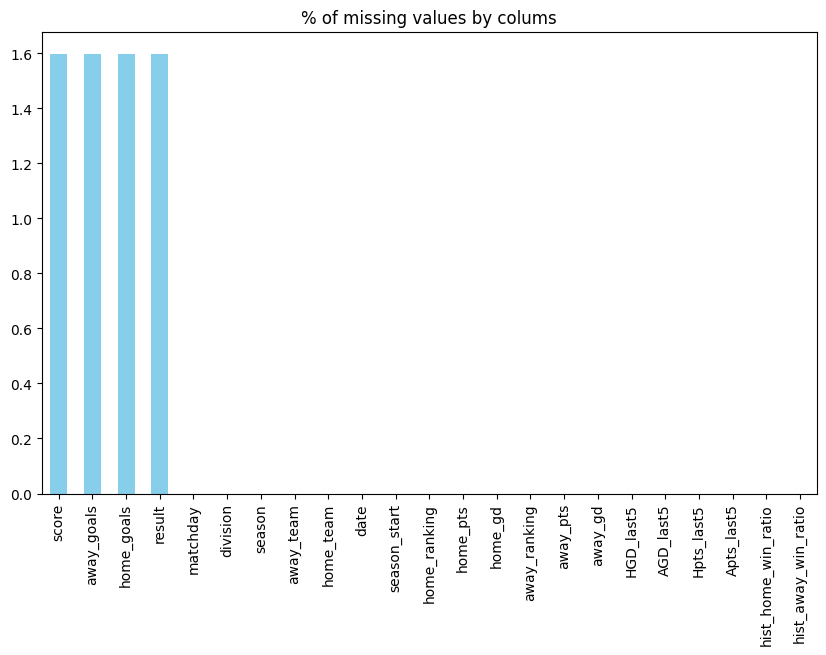

In [57]:
# ----------------------
# NA's
# ----------------------

# total of Na´s
print(f"Total of missing values: {df_rank.isna().sum().sum()}")

# verification of missing values by columns
print(f"Missing values by columns: \n {df_rank.isna().sum()}")

# plot of missing values
df_rank.isnull().mean().mul(100).sort_values(ascending=False).plot(kind='bar', figsize=(10,6), color='skyblue', title='% of missing values by colums')

In [58]:
# column score
print(f"Los valores nulos en 'score' van desde {df_rank.loc[df_rank['score'].isna(), 'date'].min().date()} hasta {df_rank.loc[df_rank['score'].isna(), 'date'].max().date()}.")

Los valores nulos en 'score' van desde 2021-08-30 hasta 2022-05-29.


In [59]:
# ----------------------
# Duplicates
# ----------------------

# duplicated values
print(f"Total of values duplicates: {df_rank.duplicated().sum()}")

Total of values duplicates: 0


In [60]:
# -------------------------------------------
# Final Visualization
# -------------------------------------------
df_rank.head(10)

,season,division,matchday,date,home_team,away_team,score,home_goals,away_goals,result,...,home_gd,away_ranking,away_pts,away_gd,HGD_last5,AGD_last5,Hpts_last5,Apts_last5,hist_home_win_ratio,hist_away_win_ratio
0,1928-1929,1,1,1929-02-10,Arenas Club,Athletic Madrid,2:3,2.0,3.0,1,...,0.0,10,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5
1,1928-1929,1,1,1929-02-10,Espanyol,Real Unión,3:2,3.0,2.0,0,...,0.0,10,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5
2,1928-1929,1,1,1929-02-10,Real Madrid,Catalunya,5:0,5.0,0.0,0,...,0.0,10,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5
3,1928-1929,1,1,1929-02-10,Donostia,Athletic,1:1,1.0,1.0,2,...,0.0,10,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5
4,1928-1929,1,1,1929-02-12,Racing,Barcelona,0:2,0.0,2.0,1,...,0.0,10,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5
5,1928-1929,1,2,1929-02-17,Barcelona,Real Madrid,1:2,1.0,2.0,1,...,2.0,1,3.0,5.0,2.0,5.0,3.0,3.0,0.5,0.5
6,1928-1929,1,2,1929-02-17,Athletic,Espanyol,9:0,9.0,0.0,0,...,0.0,3,3.0,1.0,0.0,1.0,1.0,3.0,0.5,0.5
7,1928-1929,1,2,1929-02-17,Athletic Madrid,Donostia,0:3,0.0,3.0,1,...,1.0,4,1.0,0.0,1.0,0.0,3.0,1.0,0.5,0.5
8,1928-1929,1,2,1929-02-17,Real Unión,Racing,3:1,3.0,1.0,0,...,-1.0,6,0.0,-2.0,-1.0,-2.0,0.0,0.0,0.5,0.5
9,1928-1929,1,2,1929-02-17,Catalunya,Arenas Club,5:2,5.0,2.0,0,...,-5.0,5,0.0,-1.0,-5.0,-1.0,0.0,0.0,0.5,0.5


In [61]:
# -------------------------------------------
# Target count
# -------------------------------------------
df_rank["result"].value_counts()     # 0: win home team
                                # 1: win away team
                                # 2: tie

result
0    25321
2    12280
1    10399
Name: count, dtype: int64

### Machine Learning Models:

This section focuses on the **modeling stage**, where the cleaned and preprocessed dataset is used to train and evaluate a predictive model capable of classifying football match outcomes.  

As presented in the *La Liga – Task 1* script, four different algorithms were initially **developed and tested**:  
1. **Decision Tree Classifier**  
2. **Random Forest Classifier**  
3. **XGBoost Classifier**  
4. **Artificial Neural Network (ANN)**  

These models were first evaluated using the **original dataset**, that is, before the creation of the newly engineered variables. The same evaluation process was then repeated using the **enriched dataset**, which included the additional variables generated during the feature engineering stage. In both cases, model performance was compared based on key metrics such as **accuracy**, **specificity** (true negative rate), and **sensitivity** (true positive rate).  

After this comparison, it was determined that the **Random Forest** model delivered the best overall performance when applied to the **expanded dataset**, standing out particularly in terms of **accuracy**, while maintaining strong robustness and generalization capability. For this reason, the **Random Forest** was selected as the **final predictive model** for the dataset containing all the engineered variables.  

The modeling workflow begins by defining three data subsets:  
- A **trainable dataset** (`df_trainable`), which includes only matches with an available target variable (`result`), meaning those played **before August 30, 2021**.  
- Within this dataset, the data is split into **80% for training** and **20% for testing**, using **class stratification** to ensure that all three categories (`0`: home win, `1`: away win, `2`: draw) are proportionally represented in both subsets.  
- A **prediction dataset**, which contains matches with missing values in the `score` column. These correspond to the period between **August 30, 2021, and May 29, 2022**, representing the **matches that had not yet been played** at the time of data collection. This dataset is later used to **generate the model’s predictions**.  

Before training, a **Min-Max scaling** was applied to normalize the range of numerical variables and improve model stability. To avoid **data leakage**, the **scaler (`MinMaxScaler`) was fitted exclusively on the training data**, and the same transformation was subsequently applied to the test and prediction sets. This ensures that no information from validation or prediction data influences the model-fitting process.  

The resulting dimensions of each subset after scaling were as follows:  
- **Training set (scaled):** (38,400, 18)  
- **Test set (scaled):** (9,600, 18)  
- **Prediction set (scaled, null values):** (780, 18)  

Finally, the **Random Forest model**, configured with the previously optimized hyperparameters, was trained using the scaled training data and evaluated on the test set. The evaluation focused primarily on **accuracy**, while also considering **specificity** and **sensitivity**, ensuring balanced performance across all outcome classes.  

This approach resulted in an **efficient, robust, and well-calibrated model**, capable of **predicting the outcomes of unplayed matches** by leveraging all available historical data, maximizing generalization capacity, and minimizing the risk of overfitting.

#### Split Data:

In [62]:
##############
# Split Data #
##############

# ------------------------------------
# Train / Test / Predict Split
# ------------------------------------

# 1) Rango nulo
fecha_ini = pd.Timestamp('2021-08-30')
fecha_fin = pd.Timestamp('2022-05-29')

# 2) Trainable (para train/test)
df_trainable = df_rank[df_rank['date'] < fecha_ini].dropna(subset=['result'])

# 3) A predecir (nulos en el rango)
df_to_predict = df_rank[
    (df_rank['date'] >= fecha_ini) & (df_rank['date'] <= fecha_fin) & (df_rank['result'].isna())
].drop(columns=['score', 'result', 'home_goals', 'away_goals', 'date'])

# 4) X, y (features and target)
X = df_trainable.drop(columns=['score', 'result', 'home_goals', 'away_goals', 'date'])
y = df_trainable['result'].astype(int)

# 5) Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 6) Visualización Inicial 
print("Tamaño train (raw):", X_train.shape)
print("Tamaño test (raw):", X_test.shape)
print("Tamaño a predecir (raw nulos):", df_to_predict.shape)

# ------------------------------------
# Target Encoding para categóricas
# ------------------------------------

# 1) Detectar columnas categóricas desde el TRAIN
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# 2) Encoder estilo CatBoost (fit SOLO con train)
cbe = CatBoostEncoder(cols=cat_cols, random_state=42)
cbe.fit(X_train, y_train)

# 3) Alinear df_to_predict a las MISMAS columnas y orden que X
X_to_predict_base = df_to_predict.reindex(columns=X.columns)

# 4) Transformar train, test y a predecir con el MISMO encoder
X_train = cbe.transform(X_train).fillna(0)
X_test  = cbe.transform(X_test).fillna(0)
X_to_predict = cbe.transform(X_to_predict_base).fillna(0)

print("-----------------------------------------------------")
print("Tamaño train (enc):", X_train.shape)
print("Tamaño test (enc):", X_test.shape)
print("Tamaño a predecir (enc nulos):", X_to_predict.shape)

# ------------------------------------
# Escalado Min-Max (sin data leakage)
# ------------------------------------

# 1) Definir y ajustar el scaler SOLO con TRAIN
scaler = MinMaxScaler()
scaler.fit(X_train)  # <- fit únicamente con datos de entrenamiento

# 2) Transformar train, test y a predecir con el MISMO scaler
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test  = pd.DataFrame(scaler.transform(X_test),  columns=X_test.columns,  index=X_test.index)
X_to_predict = pd.DataFrame(scaler.transform(X_to_predict), columns=X_to_predict.columns, index=X_to_predict.index)

print("-----------------------------------------------------")
print("Tamaño train (scaled):", X_train.shape)
print("Tamaño test (scaled):", X_test.shape)
print("Tamaño a predecir (scaled nulos):", X_to_predict.shape)

Tamaño train (raw): (38400, 18)
Tamaño test (raw): (9600, 18)
Tamaño a predecir (raw nulos): (780, 18)
-----------------------------------------------------
Tamaño train (enc): (38400, 18)
Tamaño test (enc): (9600, 18)
Tamaño a predecir (enc nulos): (780, 18)
-----------------------------------------------------
Tamaño train (scaled): (38400, 18)
Tamaño test (scaled): (9600, 18)
Tamaño a predecir (scaled nulos): (780, 18)


In [63]:
##################
# Names Features #
##################
print(X.columns)

Index(['season', 'division', 'matchday', 'home_team', 'away_team',
       'season_start', 'home_ranking', 'home_pts', 'home_gd', 'away_ranking',
       'away_pts', 'away_gd', 'HGD_last5', 'AGD_last5', 'Hpts_last5',
       'Apts_last5', 'hist_home_win_ratio', 'hist_away_win_ratio'],
      dtype='object')


In [64]:
#######################
# Value counts target #
#######################

print("Value counts y_train:", y_train.value_counts())
print("\n")
print("Value counts y_test:", y_test.value_counts())

Value counts y_train: result
0    20257
2     9824
1     8319
Name: count, dtype: int64


Value counts y_test: result
0    5064
2    2456
1    2080
Name: count, dtype: int64


#### Random Forest:

In [65]:
# --------------------------------
# Definir Modelo (Tunning)
# --------------------------------

# 1) Definir el modelo
model_rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# 2) Cuadrícula de hiperparámetros
# param_grid_rf = {
#     'n_estimators': [100, 200],               # número de árboles
#     'criterion': ['gini', 'entropy'],         # función de impureza
#     'max_depth': [None, 5, 10],               # profundidad máxima
#     'min_samples_split': np.arange(2, 9, 2),  # mínimo de muestras para dividir
#     'min_samples_leaf': np.arange(1, 9, 2),   # mínimo de muestras por hoja
#     'max_features': ['sqrt', 'log2', None],   # número de features por split
#     'max_leaf_nodes': [None, 20, 50],         # nodos hoja máximos
#     'bootstrap': [True, False]                # si se usa bootstrap o no
# }

param_grid_rf = {
    'n_estimators': [200],        # suficiente para estabilidad sin disparar tiempo
    'criterion': ['gini'],        # 'gini' suele ser más rápido que 'entropy'
    'max_depth': [None, 10],      # sin límite o un tope razonable
    'min_samples_split': [2, 5],  # control de sobreajuste
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt'],     # estándar en clasificación
    'bootstrap': [True]           # permite OOB si lo usas
}

# 3) GridSearchCV (validación cruzada 5 pliegues)
grid_search_rf = GridSearchCV(
    estimator=model_rf,
    param_grid=param_grid_rf,
    cv=5,
    n_jobs=-1,
    scoring='accuracy'
)

# 4) Ajustar el modelo
grid_search_rf.fit(X_train, y_train)

# 5) Resultados del tuning
print("Mejores parámetros encontrados:", grid_search_rf.best_params_)
print("Mejor modelo encontrado:", grid_search_rf.best_estimator_)

# 6) Evaluación
best_model_rf = grid_search_rf.best_estimator_
y_pred_rf = best_model_rf.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Accuracy Random Forest (Hyperparameter Tuning): {accuracy_rf:.4f}')

Mejores parámetros encontrados: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mejor modelo encontrado: RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)
Accuracy Random Forest (Hyperparameter Tuning): 0.5289


### PART - 3 
## **Model Evaluation**

In this section, we perform the **evaluation of the Random Forest model** to analyze its performance and identify which factors most influence the prediction of football match outcomes.

### **1. Feature Importances**

The first analysis focuses on the **feature importances** calculated by the Random Forest model.  
This measure indicates how much each variable contributes to improving prediction accuracy by reducing impurity during the model’s training process.

From the graph, we can observe that the most influential variables are:

- **home_team** → The most important feature, confirming the strong *home advantage* effect in determining match results.  
- **away_team** → Also highly relevant, indicating that the strength and identity of the visiting team greatly affect the prediction.  
- **season** → Captures seasonal variations such as player transfers, team form, or overall league dynamics.  
- **season_start** → Reflects temporal effects related to the beginning of the season, influencing early performance patterns.  
- **away_gd** and **home_gd** → Represent recent goal differences and highlight how recent offensive and defensive performances impact the model’s decisions.

Overall, the model relies mainly on **contextual and team-related features**, which aligns with the intuition that both *team identity* and *recent performance* are key drivers of football match outcomes.

---

### **2. Confusion Matrix**

The **confusion matrix** shows how the model distributes correct and incorrect predictions among the three possible outcomes:
- `0`: home win  
- `1`: away win  
- `2`: draw  

Based on the results:

| True / Predicted | 0 (Home) | 1 (Away) | 2 (Draw) |
|------------------:|----------:|----------:|----------:|
| **0 (Home)** | 4594 | 228 | 242 |
| **1 (Away)** | 1622 | 295 | 163 |
| **2 (Draw)** | 2069 | 199 | 188 |

The model **performs best when predicting home wins (class 0)**, correctly identifying the majority of these cases.  
However, it **struggles with away wins (1) and draws (2)**, which are frequently misclassified as home wins.  
This indicates a **bias toward the dominant class (home victories)**, a common pattern in football prediction tasks due to the **class imbalance** inherent in match outcomes.

### **3. Classification Report**

The **classification report** provides a detailed quantitative assessment of the Random Forest model’s performance for each class:

| Class | Precision | Recall | F1-score | Support |
|:------|-----------:|--------:|-----------:|---------:|
| 0 (Home win) | 0.5545 | 0.9072 | 0.6883 | 5064 |
| 1 (Away win) | 0.4086 | 0.1418 | 0.2106 | 2080 |
| 2 (Draw) | 0.3170 | 0.0765 | 0.1233 | 2456 |
| **Accuracy** |  |  | **0.5289** | 9600 |
| **Macro avg** | 0.4267 | 0.3752 | 0.3407 |  |
| **Weighted avg** | 0.4621 | 0.5289 | 0.4402 |  |

**Interpretation:**
- The model achieves an overall **accuracy of 52.9%**, which indicates a moderate predictive performance.  
- It performs **very well for home wins (class 0)**, with a high recall of **0.91**, meaning most home victories are correctly identified.  
- However, the **recall for away wins (0.14)** and **draws (0.08)** is notably low, showing that the model tends to misclassify these outcomes as home wins.  
- The **low F1-scores** for the minority classes highlight a clear **bias toward the majority class**, which is a common issue in football prediction tasks due to the **natural imbalance of results** (home wins being far more frequent).

---
#### **4 Overall Interpretation**

Overall, the results indicate that the **Random Forest model achieved the best performance** among all the algorithms tested.  
Its accuracy and balance between precision and recall show that **the inclusion of the new engineered variables notably improved predictive performance**, allowing the model to better capture the underlying dynamics of football match outcomes.

It can be observed that, although the model **tends to favor certain classes due to its natural bias toward the most frequent outcomes**, it **does not exclusively predict a single class**.  
In particular, while it shows some **inertia toward predicting home wins (class 0)**  a common effect in football modeling due to class imbalance  it is still capable of **differentiating and correctly identifying a portion of away wins (class 1) and draws (class 2)**.  
This demonstrates that the model is not “stuck” in one outcome, but rather reflects the real distribution of football results, where home victories dominate.

Despite these challenges, the Random Forest remains **the most effective and stable model**, showing significant improvements thanks to the **additional contextual and performance-based features** (e.g., recent form, goal differences, ranking ratios).  
These enriched variables allow the model to learn more nuanced relationships between teams and match contexts.

To further enhance its performance, future work could:
- Apply **class balancing techniques** (e.g., SMOTE or class weighting) to mitigate the bias toward frequent outcomes.  
- Incorporate **more detailed match statistics** such as possession, shots, or player form.  
- Explore **ensemble or hybrid methods** to complement the Random Forest’s strengths and improve detection of minority classes.

In summary, although the Random Forest model still shows a slight tendency toward the majority class, it **does not collapse into predicting only one outcome**.  
Instead, it demonstrates a strong learning capacity, capturing realistic match dynamics and achieving **the best overall predictive performance among all tested models**.

---


Feature Importances Random Forest:
 home_team              0.079086
away_team              0.078853
season                 0.068574
season_start           0.066910
away_gd                0.063403
home_gd                0.062986
away_pts               0.059602
home_pts               0.058519
AGD_last5              0.053706
home_ranking           0.053394
HGD_last5              0.053332
away_ranking           0.052724
matchday               0.052526
hist_away_win_ratio    0.048287
Apts_last5             0.046339
hist_home_win_ratio    0.046317
Hpts_last5             0.044943
division               0.010501
dtype: float64


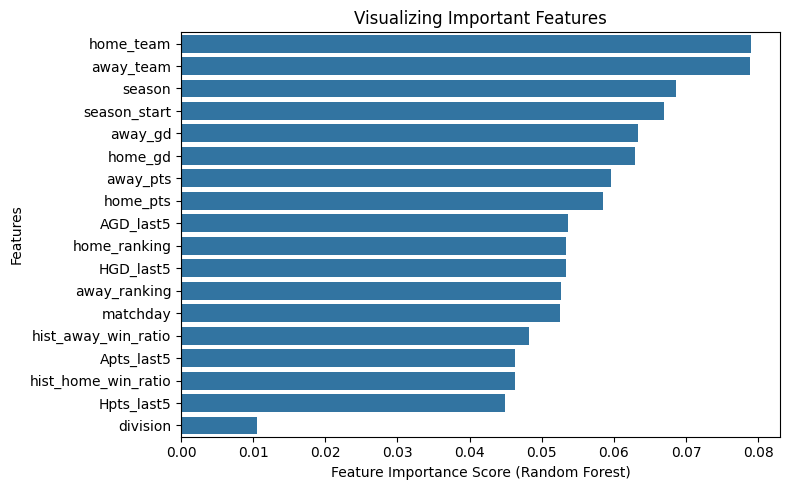

In [66]:
# --------------------------------------------------
# Feature importances (usar el modelo entrenado)
# --------------------------------------------------

# features importances
importances = best_model_rf.feature_importances_

# name columns
feature_names = getattr(X_train, "columns", [f"f{i}" for i in range(len(importances))])
feature_scores = (
    pd.Series(importances, index=feature_names)
      .sort_values(ascending=False)
)

print('Feature Importances Random Forest:\n', feature_scores)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=feature_scores.values, y=feature_scores.index)
plt.xlabel('Feature Importance Score (Random Forest)')
plt.ylabel('Features')
plt.title('Visualizing Important Features')
plt.tight_layout()
plt.show()

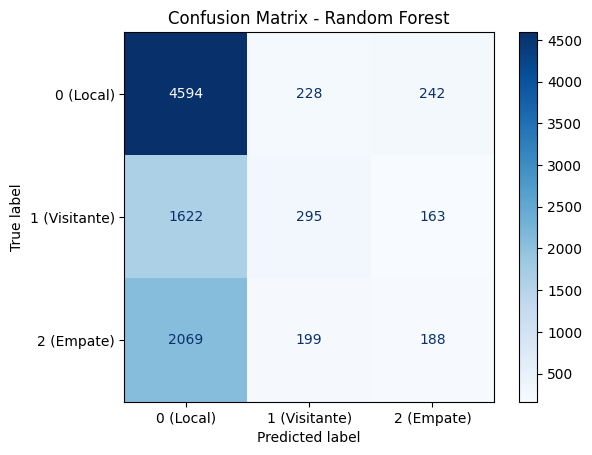

In [67]:
# --------------------------------
# Confusion Matrix
# --------------------------------

# labels
labels_idx = [0, 1, 2]                                          # clases verdaderas
display_names = ['0 (Local)', '1 (Visitante)', '2 (Empate)']    # solo etiquetas visibles

# see confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=display_names)
disp_rf.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Random Forest")
plt.show()

In [68]:
# --------------------------------
# Classification Report
# --------------------------------
print('Classification Report:\n', classification_report(y_test, y_pred_rf, labels=[0, 1, 2],target_names=["1 (Local)", "2 (Visitante)", "3 (Empate)"],digits=4))

Classification Report:
                precision    recall  f1-score   support

    1 (Local)     0.5545    0.9072    0.6883      5064
2 (Visitante)     0.4086    0.1418    0.2106      2080
   3 (Empate)     0.3170    0.0765    0.1233      2456

     accuracy                         0.5289      9600
    macro avg     0.4267    0.3752    0.3407      9600
 weighted avg     0.4621    0.5289    0.4402      9600



In [69]:
# --------------------------------
# Predictions
# --------------------------------

# prediction to new data
y_pred_new_rf = best_model_rf.predict(X_to_predict)

In [70]:
# --------------------------------
# Dataframe Results
# --------------------------------

# prediction to dataframe
df_pred = pd.DataFrame(y_pred_new_rf, columns=['prediction'])

# index
df_pred.index = df_to_predict.index

# df result
df_result = pd.concat([df_to_predict, df_pred], axis=1)

# visualization
df_result.head()

,season,division,matchday,home_team,away_team,season_start,home_ranking,home_pts,home_gd,away_ranking,away_pts,away_gd,HGD_last5,AGD_last5,Hpts_last5,Apts_last5,hist_home_win_ratio,hist_away_win_ratio,prediction
47968,2021-2022,1,4,Levante,Rayo Vallecano,2021,11,2.0,-1.0,9,3.0,0.0,-0.333333,0.000000,0.666667,1.000000,0.500,0.500,2
47969,2021-2022,1,4,Espanyol,Atlético Madrid,2021,14,2.0,-1.0,4,7.0,2.0,-0.333333,0.666667,0.666667,2.333333,0.375,0.375,1
47970,2021-2022,1,4,Real Madrid,Celta de Vigo,2021,1,7.0,4.0,16,1.0,-2.0,1.333333,-0.666667,2.333333,0.333333,0.800,0.000,0
47971,2021-2022,1,4,Villarreal,Alavés,2021,10,3.0,0.0,18,0.0,-7.0,0.000000,-2.333333,1.000000,0.000000,0.400,0.600,0
47972,2021-2022,1,4,Sevilla FC,Barcelona,2021,2,7.0,4.0,3,7.0,3.0,1.333333,1.000000,2.333333,2.333333,0.000,0.700,1
